In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sun Feb 11 18:35:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
| 39%   68C    P2             248W / 450W |  21010MiB / 24564MiB |     67%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.bottleneck_swae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 1024
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = None
hp.N = 256
hp.z_activation = F.tanh

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 13.992919921875
encoder.convs 5.989013671875
encoder.linear 8.00390625
prior 0.0
latent 0.0
decoder 14.028697967529297
decoder.linear 8.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train02.11-7/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 173272
-rw-rw-r-- 1 scpark scpark   976764  2월 11 18:35 events.out.tfevents.1707643422.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark 88225876  2월 11 18:34 save_10000
-rw-rw-r-- 1 scpark scpark 88220012  2월 11 18:23 save_0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


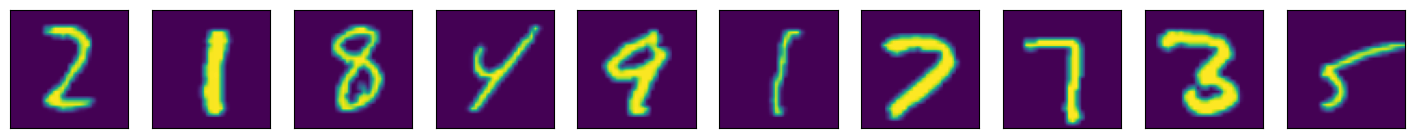

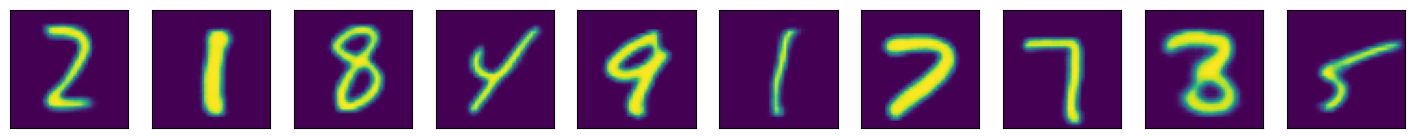

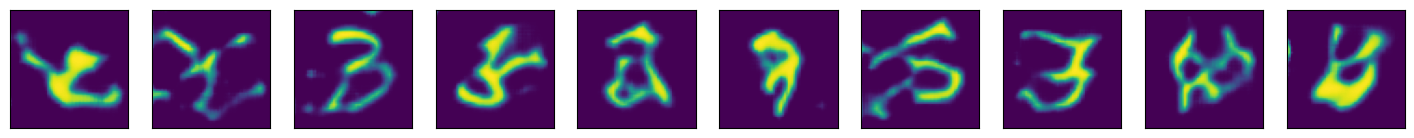

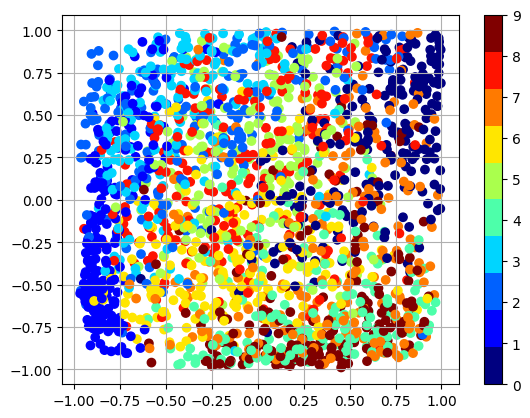

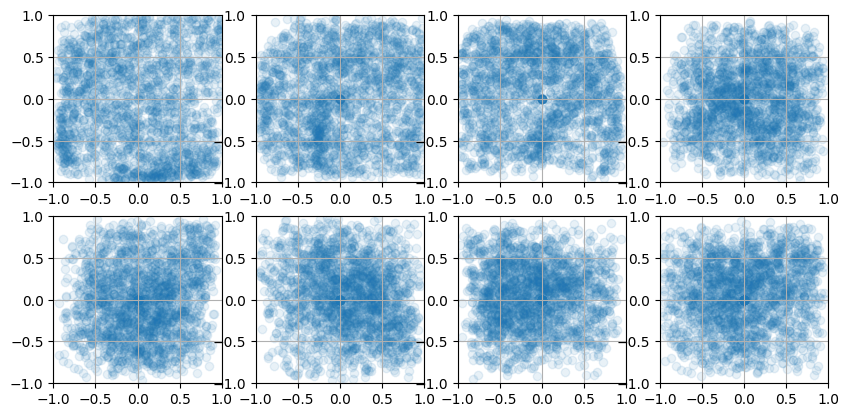

8001
swae_loss 0.013361616060137749
recon_loss 0.010779093019664288
8002
swae_loss 0.015851754695177078
recon_loss 0.008656625635921955
8003
swae_loss 0.01354499813169241
recon_loss 0.010544070973992348
8004
swae_loss 0.016397887840867043
recon_loss 0.01057977881282568
8005
swae_loss 0.012456796132028103
recon_loss 0.010807637125253677
8006
swae_loss 0.013528130017220974
recon_loss 0.012745043262839317
8007
swae_loss 0.017037926241755486
recon_loss 0.009253082796931267
8008
swae_loss 0.012504102662205696
recon_loss 0.012160098180174828
8009
swae_loss 0.012590210884809494
recon_loss 0.01000423263758421
8010
swae_loss 0.014371742494404316
recon_loss 0.009475817903876305
8011
swae_loss 0.012389544397592545
recon_loss 0.010900764726102352
8012
swae_loss 0.013838918879628181
recon_loss 0.011183038353919983
8013
swae_loss 0.016075313091278076
recon_loss 0.009584236890077591
8014
swae_loss 0.013136124238371849
recon_loss 0.010608116164803505
8015
swae_loss 0.017738915979862213
recon_loss 0.00

swae_loss 0.01382740493863821
recon_loss 0.009096117690205574
8125
swae_loss 0.013733078725636005
recon_loss 0.009335729293525219
8126
swae_loss 0.014896661974489689
recon_loss 0.011043671518564224
8127
swae_loss 0.013489780016243458
recon_loss 0.011024406179785728
8128
swae_loss 0.015427241101861
recon_loss 0.009566701017320156
8129
swae_loss 0.012921636924147606
recon_loss 0.009204300120472908
8130
swae_loss 0.014815974980592728
recon_loss 0.008842197246849537
8131
swae_loss 0.012818758375942707
recon_loss 0.011086933314800262
8132
swae_loss 0.01546352356672287
recon_loss 0.012588879093527794
8133
swae_loss 0.0124454814940691
recon_loss 0.009022451937198639
8134
swae_loss 0.01300827693194151
recon_loss 0.010173246264457703
8135
swae_loss 0.016407756134867668
recon_loss 0.011610503308475018
8136
swae_loss 0.015929214656352997
recon_loss 0.010772737674415112
8137
swae_loss 0.01529222447425127
recon_loss 0.010755948722362518
8138
swae_loss 0.017022933810949326
recon_loss 0.0099693331867

8246
swae_loss 0.015652870759367943
recon_loss 0.010345274582505226
8247
swae_loss 0.013667070306837559
recon_loss 0.010399220511317253
8248
swae_loss 0.014168194495141506
recon_loss 0.010684623382985592
8249
swae_loss 0.01385665126144886
recon_loss 0.01124262623488903
8250
swae_loss 0.01492284145206213
recon_loss 0.010800382122397423
8251
swae_loss 0.01523624174296856
recon_loss 0.010049684904515743
8252
swae_loss 0.01415752898901701
recon_loss 0.010894974693655968
8253
swae_loss 0.016593433916568756
recon_loss 0.008972503244876862
8254
swae_loss 0.013160478323698044
recon_loss 0.012808199040591717
8255
swae_loss 0.01390331145375967
recon_loss 0.011360792443156242
8256
swae_loss 0.015209319069981575
recon_loss 0.009761529043316841
8257
swae_loss 0.013070681132376194
recon_loss 0.010310241021215916
8258
swae_loss 0.014771895483136177
recon_loss 0.009939073584973812
8259
swae_loss 0.012276900000870228
recon_loss 0.009280875325202942
8260
swae_loss 0.014521458186209202
recon_loss 0.01069

8368
swae_loss 0.014489476568996906
recon_loss 0.010492146015167236
8369
swae_loss 0.014587324112653732
recon_loss 0.010422253981232643
8370
swae_loss 0.014814147725701332
recon_loss 0.009324789047241211
8371
swae_loss 0.014638697728514671
recon_loss 0.009758311323821545
8372
swae_loss 0.01330820843577385
recon_loss 0.011467731557786465
8373
swae_loss 0.01748647913336754
recon_loss 0.009241393767297268
8374
swae_loss 0.015853065997362137
recon_loss 0.010287052020430565
8375
swae_loss 0.01427428238093853
recon_loss 0.012871842831373215
8376
swae_loss 0.014653193764388561
recon_loss 0.011117057874798775
8377
swae_loss 0.014832241460680962
recon_loss 0.009925385937094688
8378
swae_loss 0.012921467423439026
recon_loss 0.010359145700931549
8379
swae_loss 0.010974287986755371
recon_loss 0.012786313891410828
8380
swae_loss 0.01572265289723873
recon_loss 0.011502242647111416
8381
swae_loss 0.012804113328456879
recon_loss 0.010845854878425598
8382
swae_loss 0.013669103384017944
recon_loss 0.009

8491
swae_loss 0.015101541765034199
recon_loss 0.010150919668376446
8492
swae_loss 0.012511168606579304
recon_loss 0.01297266036272049
8493
swae_loss 0.01465369388461113
recon_loss 0.01005119364708662
8494
swae_loss 0.015137256123125553
recon_loss 0.008577904663980007
8495
swae_loss 0.012959884479641914
recon_loss 0.009486418217420578
8496
swae_loss 0.01099398359656334
recon_loss 0.009103585965931416
8497
swae_loss 0.013250693678855896
recon_loss 0.011233421042561531
8498
swae_loss 0.013757865875959396
recon_loss 0.010620690882205963
8499
swae_loss 0.016356421634554863
recon_loss 0.009887888096272945
8500
swae_loss 0.016378818079829216
recon_loss 0.010373015888035297
8501
swae_loss 0.014785942621529102
recon_loss 0.011828234419226646
8502
swae_loss 0.014103940688073635
recon_loss 0.009583132341504097
8503
swae_loss 0.012777959927916527
recon_loss 0.010490426793694496
8504
swae_loss 0.017639240249991417
recon_loss 0.012822194024920464
8505
swae_loss 0.012478434480726719
recon_loss 0.010

8614
swae_loss 0.014117577113211155
recon_loss 0.00981525331735611
8615
swae_loss 0.01438575517386198
recon_loss 0.011521926149725914
8616
swae_loss 0.013496700674295425
recon_loss 0.0105638038367033
8617
swae_loss 0.012927176430821419
recon_loss 0.01196806039661169
8618
swae_loss 0.016351526603102684
recon_loss 0.009846121072769165
8619
swae_loss 0.011631145142018795
recon_loss 0.009875337593257427
8620
swae_loss 0.014465376734733582
recon_loss 0.009570630267262459
8621
swae_loss 0.010269999504089355
recon_loss 0.009763313457369804
8622
swae_loss 0.014763270504772663
recon_loss 0.011542655527591705
8623
swae_loss 0.013940200209617615
recon_loss 0.00957618560642004
8624
swae_loss 0.011401193216443062
recon_loss 0.010859966278076172
8625
swae_loss 0.014290086925029755
recon_loss 0.01089777797460556
8626
swae_loss 0.012538456358015537
recon_loss 0.010212793946266174
8627
swae_loss 0.015276645310223103
recon_loss 0.011551626026630402
8628
swae_loss 0.014434568583965302
recon_loss 0.011203

swae_loss 0.014795433729887009
recon_loss 0.01000242680311203
8737
swae_loss 0.01566188596189022
recon_loss 0.01056862622499466
8738
swae_loss 0.014319436624646187
recon_loss 0.010127819143235683
8739
swae_loss 0.01541308593004942
recon_loss 0.009546279907226562
8740
swae_loss 0.013995377346873283
recon_loss 0.011188587173819542
8741
swae_loss 0.011581226252019405
recon_loss 0.011384202167391777
8742
swae_loss 0.012945343740284443
recon_loss 0.011592291295528412
8743
swae_loss 0.015123587101697922
recon_loss 0.008668764494359493
8744
swae_loss 0.013358678668737411
recon_loss 0.010518151335418224
8745
swae_loss 0.012289904989302158
recon_loss 0.011545228771865368
8746
swae_loss 0.013270366936922073
recon_loss 0.008649313822388649
8747
swae_loss 0.01688854768872261
recon_loss 0.01230737566947937
8748
swae_loss 0.014060246758162975
recon_loss 0.010973578318953514
8749
swae_loss 0.013058071956038475
recon_loss 0.008852249011397362
8750
swae_loss 0.017310747876763344
recon_loss 0.0096474057

swae_loss 0.012042474932968616
recon_loss 0.010151607915759087
8859
swae_loss 0.013998678885400295
recon_loss 0.011324074119329453
8860
swae_loss 0.018617182970046997
recon_loss 0.009635079652071
8861
swae_loss 0.013986196368932724
recon_loss 0.009261397644877434
8862
swae_loss 0.014647592790424824
recon_loss 0.01096423715353012
8863
swae_loss 0.013586382381618023
recon_loss 0.011745467782020569
8864
swae_loss 0.013559450395405293
recon_loss 0.009775210171937943
8865
swae_loss 0.012313945218920708
recon_loss 0.009449121542274952
8866
swae_loss 0.011748850345611572
recon_loss 0.00911466870456934
8867
swae_loss 0.014942224137485027
recon_loss 0.008904075250029564
8868
swae_loss 0.013017515651881695
recon_loss 0.012693308293819427
8869
swae_loss 0.013827219605445862
recon_loss 0.01061642449349165
8870
swae_loss 0.013555418699979782
recon_loss 0.010339655913412571
8871
swae_loss 0.012406794354319572
recon_loss 0.010277176275849342
8872
swae_loss 0.013342407532036304
recon_loss 0.0094454074


KeyboardInterrupt



In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'wise_min_loss' in key:
                    loss = loss + data[key] * 1e+4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
            
            _z = data['z'].data.cpu().numpy()

            plt.figure(figsize=[10, 10])
            for i in range(8):
                plt.subplot(4, 4, i+1)
                plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
                plt.grid()
                plt.xlim([-1, 1])
                plt.ylim([-1, 1])

            plt.show()
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
plt.figure(figsize=[10, 10])
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
    plt.grid()
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    
plt.show()